# GANgster
In this notebook we will try to generate mugshots with our generator

In [1]:
import os
import glob
import json

import torch
from torch import nn

import PIL
import time

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [2]:
image_size = 64
generator_entry = 100

In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("running on GPU")
else:
    device = torch.device("cpu")
    print("running on GPU")

running on GPU


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)), transforms.Resize((image_size, image_size))]
)

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images_folder, transform=None):
        self.df = []
        self.transform = transform
        for filepath in glob.glob(f"{images_folder}/*/*F.png"):
            image = PIL.Image.open(filepath)
            if self.transform is not None:
                image = self.transform(image)
            self.df.append((image, os.path.split(filepath)[1].split(".")[0]))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        return self.df[index]

In [6]:
train_set = CustomDataset(
    images_folder="../data/sd18/single", transform=transform
)

In [7]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

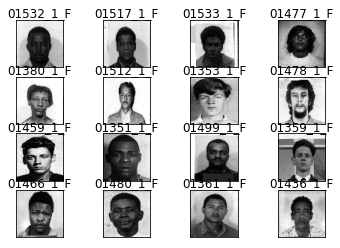

In [8]:
real_samples, real_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    ax.imshow(real_samples[i].reshape(image_size, image_size), cmap="gray")
    ax.set_title(real_labels[i], fontsize=12, pad=1.0)
    ax.set_xticks([])
    ax.set_yticks([])

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size ** 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), image_size ** 2)
        output = self.model(x)
        return output

In [10]:
discriminator = Discriminator().to(device=device)

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(generator_entry, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, image_size ** 2),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, image_size, image_size)
        return output

In [12]:
generator = Generator().to(device=device)

In [13]:
lr = 0.001
num_epochs = 250000
loss_function = nn.BCELoss()

In [14]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [15]:
per_100_time = []


epoch_start = time.time()
for epoch in range(num_epochs):
    loss_discriminator = 0
    loss_generator = 0
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        
        real_samples = real_samples.to(device=device)
        real_samples_size = real_samples.shape[0]

        # Set the labels of the real data to one (Using the size of the real samples array)
        real_samples_labels = torch.ones((real_samples_size, 1)).to(device=device)

        # Set the labels of the fake data to zero
        latent_space_samples = torch.randn((real_samples_size, generator_entry)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((real_samples_size, 1)).to(device=device)

        # Concatenate true and fake data
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)

        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((real_samples_size, generator_entry)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

    # Show loss
    if epoch % 100 == 0 and epoch != 0:
        per_100_time.append(time.time() - epoch_start)
        epoch_start = time.time()
        ld = str(round(float(loss_discriminator), 10)).zfill(12)
        lg = str(round(float(loss_generator), 10)).zfill(12)
        it = str(round(per_100_time[-1], 4)).zfill(9)
        av = str(round(sum(per_100_time)/len(per_100_time), 2)).zfill(6)
        seconds = round(
            ((sum(per_100_time)/len(per_100_time)) * ((num_epochs - epoch)/100)),
            2
        )
        m, s = divmod(seconds, 60)
        h, m = divmod(m, 60)
        tl = "%d:%02d:%02d" % (h, m, s)
        print(f"[+] EPOCH : {str(epoch).zfill(7)} | LD.: {ld} | LG.: {lg} | IT : {it}s | AV : {av} | TL : {tl}""")

[+] EPOCH : 0000100 | LD.: 0.5900892615 | LG.: 0.8927901387 | IT : 0007.1407s | AV : 007.14 | TL : 4:57:24
[+] EPOCH : 0000200 | LD.: 000.36196661 | LG.: 1.1970980167 | IT : 0007.0038s | AV : 007.07 | TL : 4:54:26
[+] EPOCH : 0000300 | LD.: 0.4117410779 | LG.: 01.192324996 | IT : 0006.9008s | AV : 007.02 | TL : 4:51:56
[+] EPOCH : 0000400 | LD.: 0.7535598874 | LG.: 0.8284234405 | IT : 00006.908s | AV : 006.99 | TL : 4:50:42
[+] EPOCH : 0000500 | LD.: 0.5333644152 | LG.: 1.0164300203 | IT : 0006.9097s | AV : 006.97 | TL : 4:49:56
[+] EPOCH : 0000600 | LD.: 00.580769062 | LG.: 0.9717318416 | IT : 0006.9123s | AV : 006.96 | TL : 4:49:24
[+] EPOCH : 0000700 | LD.: 0.6349092722 | LG.: 1.0467792749 | IT : 0006.9057s | AV : 006.95 | TL : 4:48:57
[+] EPOCH : 0000800 | LD.: 0.4958374202 | LG.: 1.0870702267 | IT : 0006.9081s | AV : 006.95 | TL : 4:48:36
[+] EPOCH : 0000900 | LD.: 0.1688192636 | LG.: 1.2582013607 | IT : 00006.877s | AV : 006.94 | TL : 4:48:09
[+] EPOCH : 0001000 | LD.: 0.01135539

[+] EPOCH : 0007800 | LD.: 0000000000.0 | LG.: 0000000100.0 | IT : 0006.9028s | AV : 006.89 | TL : 4:38:16
[+] EPOCH : 0007900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.9075s | AV : 006.89 | TL : 4:38:09
[+] EPOCH : 0008000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.9025s | AV : 006.89 | TL : 4:38:03
[+] EPOCH : 0008100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8982s | AV : 006.89 | TL : 4:37:56
[+] EPOCH : 0008200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.9099s | AV : 006.89 | TL : 4:37:50
[+] EPOCH : 0008300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.9278s | AV : 006.89 | TL : 4:37:44
[+] EPOCH : 0008400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.9093s | AV : 006.89 | TL : 4:37:37
[+] EPOCH : 0008500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.9135s | AV : 006.89 | TL : 4:37:31
[+] EPOCH : 0008600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8564s | AV : 006.89 | TL : 4:37:23
[+] EPOCH : 0008700 | LD.: 0000000050

[+] EPOCH : 0015500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8219s | AV : 006.85 | TL : 4:27:42
[+] EPOCH : 0015600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8219s | AV : 006.85 | TL : 4:27:35
[+] EPOCH : 0015700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8244s | AV : 006.85 | TL : 4:27:28
[+] EPOCH : 0015800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8152s | AV : 006.85 | TL : 4:27:20
[+] EPOCH : 0015900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7986s | AV : 006.85 | TL : 4:27:13
[+] EPOCH : 0016000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.802s | AV : 006.85 | TL : 4:27:05
[+] EPOCH : 0016100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8079s | AV : 006.85 | TL : 4:26:58
[+] EPOCH : 0016200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8355s | AV : 006.85 | TL : 4:26:51
[+] EPOCH : 0016300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7831s | AV : 006.85 | TL : 4:26:43
[+] EPOCH : 0016400 | LD.: 0000000050

[+] EPOCH : 0023200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7947s | AV : 006.83 | TL : 4:18:09
[+] EPOCH : 0023300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.804s | AV : 006.83 | TL : 4:18:02
[+] EPOCH : 0023400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7701s | AV : 006.83 | TL : 4:17:54
[+] EPOCH : 0023500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7408s | AV : 006.83 | TL : 4:17:47
[+] EPOCH : 0023600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8013s | AV : 006.83 | TL : 4:17:40
[+] EPOCH : 0023700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.802s | AV : 006.83 | TL : 4:17:32
[+] EPOCH : 0023800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7989s | AV : 006.83 | TL : 4:17:25
[+] EPOCH : 0023900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6657s | AV : 006.83 | TL : 4:17:17
[+] EPOCH : 0024000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8028s | AV : 006.83 | TL : 4:17:10
[+] EPOCH : 0024100 | LD.: 0000000050

[+] EPOCH : 0030900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8114s | AV : 006.82 | TL : 4:08:56
[+] EPOCH : 0031000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.816s | AV : 006.82 | TL : 4:08:49
[+] EPOCH : 0031100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8269s | AV : 006.82 | TL : 4:08:42
[+] EPOCH : 0031200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.821s | AV : 006.82 | TL : 4:08:36
[+] EPOCH : 0031300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7889s | AV : 006.82 | TL : 4:08:29
[+] EPOCH : 0031400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.741s | AV : 006.82 | TL : 4:08:21
[+] EPOCH : 0031500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.796s | AV : 006.82 | TL : 4:08:14
[+] EPOCH : 0031600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.797s | AV : 006.82 | TL : 4:08:07
[+] EPOCH : 0031700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8112s | AV : 006.82 | TL : 4:08:00
[+] EPOCH : 0031800 | LD.: 0000000050

[+] EPOCH : 0038600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7992s | AV : 006.81 | TL : 4:00:01
[+] EPOCH : 0038700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8007s | AV : 006.81 | TL : 3:59:54
[+] EPOCH : 0038800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7979s | AV : 006.81 | TL : 3:59:47
[+] EPOCH : 0038900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7811s | AV : 006.81 | TL : 3:59:40
[+] EPOCH : 0039000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7895s | AV : 006.81 | TL : 3:59:33
[+] EPOCH : 0039100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7811s | AV : 006.81 | TL : 3:59:26
[+] EPOCH : 0039200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7723s | AV : 006.81 | TL : 3:59:19
[+] EPOCH : 0039300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8047s | AV : 006.81 | TL : 3:59:12
[+] EPOCH : 0039400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8017s | AV : 006.81 | TL : 3:59:05
[+] EPOCH : 0039500 | LD.: 0000000050

[+] EPOCH : 0046300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7152s | AV : 006.81 | TL : 3:51:05
[+] EPOCH : 0046400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.811s | AV : 006.81 | TL : 3:50:58
[+] EPOCH : 0046500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8028s | AV : 006.81 | TL : 3:50:51
[+] EPOCH : 0046600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7896s | AV : 006.81 | TL : 3:50:44
[+] EPOCH : 0046700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6414s | AV : 006.81 | TL : 3:50:37
[+] EPOCH : 0046800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.789s | AV : 006.81 | TL : 3:50:30
[+] EPOCH : 0046900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8001s | AV : 006.81 | TL : 3:50:23
[+] EPOCH : 0047000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8083s | AV : 006.81 | TL : 3:50:16
[+] EPOCH : 0047100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8105s | AV : 006.81 | TL : 3:50:09
[+] EPOCH : 0047200 | LD.: 0000000050

[+] EPOCH : 0054000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7101s | AV : 0006.8 | TL : 3:42:15
[+] EPOCH : 0054100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.819s | AV : 0006.8 | TL : 3:42:08
[+] EPOCH : 0054200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8198s | AV : 0006.8 | TL : 3:42:01
[+] EPOCH : 0054300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8065s | AV : 0006.8 | TL : 3:41:54
[+] EPOCH : 0054400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7789s | AV : 0006.8 | TL : 3:41:47
[+] EPOCH : 0054500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.791s | AV : 0006.8 | TL : 3:41:41
[+] EPOCH : 0054600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7925s | AV : 0006.8 | TL : 3:41:34
[+] EPOCH : 0054700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7973s | AV : 0006.8 | TL : 3:41:27
[+] EPOCH : 0054800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8061s | AV : 0006.8 | TL : 3:41:20
[+] EPOCH : 0054900 | LD.: 0000000050

[+] EPOCH : 0061700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7911s | AV : 0006.8 | TL : 3:33:26
[+] EPOCH : 0061800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7762s | AV : 0006.8 | TL : 3:33:19
[+] EPOCH : 0061900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7941s | AV : 0006.8 | TL : 3:33:12
[+] EPOCH : 0062000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8046s | AV : 0006.8 | TL : 3:33:05
[+] EPOCH : 0062100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7922s | AV : 0006.8 | TL : 3:32:58
[+] EPOCH : 0062200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7915s | AV : 0006.8 | TL : 3:32:51
[+] EPOCH : 0062300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7391s | AV : 0006.8 | TL : 3:32:44
[+] EPOCH : 0062400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7631s | AV : 0006.8 | TL : 3:32:38
[+] EPOCH : 0062500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7655s | AV : 0006.8 | TL : 3:32:31
[+] EPOCH : 0062600 | LD.: 0000000050

[+] EPOCH : 0069400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6324s | AV : 0006.8 | TL : 3:24:33
[+] EPOCH : 0069500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6304s | AV : 0006.8 | TL : 3:24:26
[+] EPOCH : 0069600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6301s | AV : 0006.8 | TL : 3:24:19
[+] EPOCH : 0069700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6279s | AV : 0006.8 | TL : 3:24:11
[+] EPOCH : 0069800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.634s | AV : 0006.8 | TL : 3:24:04
[+] EPOCH : 0069900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8138s | AV : 0006.8 | TL : 3:23:57
[+] EPOCH : 0070000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7914s | AV : 0006.8 | TL : 3:23:51
[+] EPOCH : 0070100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7924s | AV : 0006.8 | TL : 3:23:44
[+] EPOCH : 0070200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8159s | AV : 0006.8 | TL : 3:23:37
[+] EPOCH : 0070300 | LD.: 0000000050

[+] EPOCH : 0077100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8148s | AV : 006.79 | TL : 3:15:47
[+] EPOCH : 0077200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8106s | AV : 006.79 | TL : 3:15:40
[+] EPOCH : 0077300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8382s | AV : 006.79 | TL : 3:15:34
[+] EPOCH : 0077400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8159s | AV : 006.79 | TL : 3:15:27
[+] EPOCH : 0077500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6562s | AV : 006.79 | TL : 3:15:20
[+] EPOCH : 0077600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7513s | AV : 006.79 | TL : 3:15:13
[+] EPOCH : 0077700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8052s | AV : 006.79 | TL : 3:15:06
[+] EPOCH : 0077800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7508s | AV : 006.79 | TL : 3:14:59
[+] EPOCH : 0077900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7908s | AV : 006.79 | TL : 3:14:52
[+] EPOCH : 0078000 | LD.: 0000000050

[+] EPOCH : 0084800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8089s | AV : 006.79 | TL : 3:07:04
[+] EPOCH : 0084900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8042s | AV : 006.79 | TL : 3:06:58
[+] EPOCH : 0085000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7981s | AV : 006.79 | TL : 3:06:51
[+] EPOCH : 0085100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7656s | AV : 006.79 | TL : 3:06:44
[+] EPOCH : 0085200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7748s | AV : 006.79 | TL : 3:06:37
[+] EPOCH : 0085300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7532s | AV : 006.79 | TL : 3:06:30
[+] EPOCH : 0085400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8038s | AV : 006.79 | TL : 3:06:23
[+] EPOCH : 0085500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.759s | AV : 006.79 | TL : 3:06:17
[+] EPOCH : 0085600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7613s | AV : 006.79 | TL : 3:06:10
[+] EPOCH : 0085700 | LD.: 0000000050

[+] EPOCH : 0092500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7303s | AV : 006.79 | TL : 2:58:20
[+] EPOCH : 0092600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7937s | AV : 006.79 | TL : 2:58:13
[+] EPOCH : 0092700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8048s | AV : 006.79 | TL : 2:58:06
[+] EPOCH : 0092800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7933s | AV : 006.79 | TL : 2:57:59
[+] EPOCH : 0092900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8119s | AV : 006.79 | TL : 2:57:53
[+] EPOCH : 0093000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8128s | AV : 006.79 | TL : 2:57:46
[+] EPOCH : 0093100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8024s | AV : 006.79 | TL : 2:57:39
[+] EPOCH : 0093200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8345s | AV : 006.79 | TL : 2:57:32
[+] EPOCH : 0093300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.809s | AV : 006.79 | TL : 2:57:26
[+] EPOCH : 0093400 | LD.: 0000000050

[+] EPOCH : 0100200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7666s | AV : 006.79 | TL : 2:49:35
[+] EPOCH : 0100300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7829s | AV : 006.79 | TL : 2:49:29
[+] EPOCH : 0100400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7859s | AV : 006.79 | TL : 2:49:22
[+] EPOCH : 0100500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7975s | AV : 006.79 | TL : 2:49:15
[+] EPOCH : 0100600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7605s | AV : 006.79 | TL : 2:49:08
[+] EPOCH : 0100700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6937s | AV : 006.79 | TL : 2:49:01
[+] EPOCH : 0100800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6619s | AV : 006.79 | TL : 2:48:54
[+] EPOCH : 0100900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6831s | AV : 006.79 | TL : 2:48:47
[+] EPOCH : 0101000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7832s | AV : 006.79 | TL : 2:48:40
[+] EPOCH : 0101100 | LD.: 0000000050

[+] EPOCH : 0107900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7882s | AV : 006.79 | TL : 2:40:52
[+] EPOCH : 0108000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6778s | AV : 006.79 | TL : 2:40:45
[+] EPOCH : 0108100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.827s | AV : 006.79 | TL : 2:40:38
[+] EPOCH : 0108200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 000006.82s | AV : 006.79 | TL : 2:40:31
[+] EPOCH : 0108300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7793s | AV : 006.79 | TL : 2:40:24
[+] EPOCH : 0108400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7704s | AV : 006.79 | TL : 2:40:18
[+] EPOCH : 0108500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8038s | AV : 006.79 | TL : 2:40:11
[+] EPOCH : 0108600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8063s | AV : 006.79 | TL : 2:40:04
[+] EPOCH : 0108700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7403s | AV : 006.79 | TL : 2:39:57
[+] EPOCH : 0108800 | LD.: 0000000050

[+] EPOCH : 0115600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7928s | AV : 006.79 | TL : 2:32:06
[+] EPOCH : 0115700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.792s | AV : 006.79 | TL : 2:32:00
[+] EPOCH : 0115800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7891s | AV : 006.79 | TL : 2:31:53
[+] EPOCH : 0115900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7695s | AV : 006.79 | TL : 2:31:46
[+] EPOCH : 0116000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7747s | AV : 006.79 | TL : 2:31:39
[+] EPOCH : 0116100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7809s | AV : 006.79 | TL : 2:31:32
[+] EPOCH : 0116200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7824s | AV : 006.79 | TL : 2:31:26
[+] EPOCH : 0116300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7606s | AV : 006.79 | TL : 2:31:19
[+] EPOCH : 0116400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7686s | AV : 006.79 | TL : 2:31:12
[+] EPOCH : 0116500 | LD.: 0000000050

[+] EPOCH : 0123300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8036s | AV : 006.79 | TL : 2:23:23
[+] EPOCH : 0123400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7972s | AV : 006.79 | TL : 2:23:16
[+] EPOCH : 0123500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7996s | AV : 006.79 | TL : 2:23:09
[+] EPOCH : 0123600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7948s | AV : 006.79 | TL : 2:23:03
[+] EPOCH : 0123700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.767s | AV : 006.79 | TL : 2:22:56
[+] EPOCH : 0123800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.732s | AV : 006.79 | TL : 2:22:49
[+] EPOCH : 0123900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7417s | AV : 006.79 | TL : 2:22:42
[+] EPOCH : 0124000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7349s | AV : 006.79 | TL : 2:22:35
[+] EPOCH : 0124100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7515s | AV : 006.79 | TL : 2:22:28
[+] EPOCH : 0124200 | LD.: 0000000050

[+] EPOCH : 0131000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7923s | AV : 006.79 | TL : 2:14:38
[+] EPOCH : 0131100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7998s | AV : 006.79 | TL : 2:14:32
[+] EPOCH : 0131200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7987s | AV : 006.79 | TL : 2:14:25
[+] EPOCH : 0131300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8373s | AV : 006.79 | TL : 2:14:18
[+] EPOCH : 0131400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7474s | AV : 006.79 | TL : 2:14:11
[+] EPOCH : 0131500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7694s | AV : 006.79 | TL : 2:14:04
[+] EPOCH : 0131600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8002s | AV : 006.79 | TL : 2:13:58
[+] EPOCH : 0131700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7964s | AV : 006.79 | TL : 2:13:51
[+] EPOCH : 0131800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.797s | AV : 006.79 | TL : 2:13:44
[+] EPOCH : 0131900 | LD.: 0000000050

[+] EPOCH : 0138700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7933s | AV : 006.79 | TL : 2:05:54
[+] EPOCH : 0138800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7972s | AV : 006.79 | TL : 2:05:48
[+] EPOCH : 0138900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7926s | AV : 006.79 | TL : 2:05:41
[+] EPOCH : 0139000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7415s | AV : 006.79 | TL : 2:05:34
[+] EPOCH : 0139100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7626s | AV : 006.79 | TL : 2:05:27
[+] EPOCH : 0139200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8156s | AV : 006.79 | TL : 2:05:20
[+] EPOCH : 0139300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7778s | AV : 006.79 | TL : 2:05:14
[+] EPOCH : 0139400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.788s | AV : 006.79 | TL : 2:05:07
[+] EPOCH : 0139500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7162s | AV : 006.79 | TL : 2:05:00
[+] EPOCH : 0139600 | LD.: 0000000050

[+] EPOCH : 0146400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6985s | AV : 006.79 | TL : 1:57:11
[+] EPOCH : 0146500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7897s | AV : 006.79 | TL : 1:57:04
[+] EPOCH : 0146600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7478s | AV : 006.79 | TL : 1:56:57
[+] EPOCH : 0146700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7507s | AV : 006.79 | TL : 1:56:50
[+] EPOCH : 0146800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7731s | AV : 006.79 | TL : 1:56:44
[+] EPOCH : 0146900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7476s | AV : 006.79 | TL : 1:56:37
[+] EPOCH : 0147000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7756s | AV : 006.79 | TL : 1:56:30
[+] EPOCH : 0147100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8045s | AV : 006.79 | TL : 1:56:23
[+] EPOCH : 0147200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6334s | AV : 006.79 | TL : 1:56:16
[+] EPOCH : 0147300 | LD.: 0000000050

[+] EPOCH : 0154100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8017s | AV : 006.79 | TL : 1:48:27
[+] EPOCH : 0154200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7966s | AV : 006.79 | TL : 1:48:20
[+] EPOCH : 0154300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7742s | AV : 006.79 | TL : 1:48:13
[+] EPOCH : 0154400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7684s | AV : 006.79 | TL : 1:48:07
[+] EPOCH : 0154500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.782s | AV : 006.79 | TL : 1:48:00
[+] EPOCH : 0154600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7799s | AV : 006.79 | TL : 1:47:53
[+] EPOCH : 0154700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.709s | AV : 006.79 | TL : 1:47:46
[+] EPOCH : 0154800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7163s | AV : 006.79 | TL : 1:47:39
[+] EPOCH : 0154900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7612s | AV : 006.79 | TL : 1:47:33
[+] EPOCH : 0155000 | LD.: 0000000050

[+] EPOCH : 0161800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8054s | AV : 006.78 | TL : 1:39:43
[+] EPOCH : 0161900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8025s | AV : 006.78 | TL : 1:39:36
[+] EPOCH : 0162000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7783s | AV : 006.78 | TL : 1:39:30
[+] EPOCH : 0162100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8081s | AV : 006.78 | TL : 1:39:23
[+] EPOCH : 0162200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8094s | AV : 006.78 | TL : 1:39:16
[+] EPOCH : 0162300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8129s | AV : 006.78 | TL : 1:39:09
[+] EPOCH : 0162400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8205s | AV : 006.78 | TL : 1:39:03
[+] EPOCH : 0162500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8053s | AV : 006.78 | TL : 1:38:56
[+] EPOCH : 0162600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7794s | AV : 006.78 | TL : 1:38:49
[+] EPOCH : 0162700 | LD.: 0000000050

[+] EPOCH : 0169500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7868s | AV : 006.78 | TL : 1:31:00
[+] EPOCH : 0169600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8036s | AV : 006.78 | TL : 1:30:53
[+] EPOCH : 0169700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7991s | AV : 006.78 | TL : 1:30:46
[+] EPOCH : 0169800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7961s | AV : 006.78 | TL : 1:30:40
[+] EPOCH : 0169900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7866s | AV : 006.78 | TL : 1:30:33
[+] EPOCH : 0170000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7791s | AV : 006.78 | TL : 1:30:26
[+] EPOCH : 0170100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7418s | AV : 006.78 | TL : 1:30:19
[+] EPOCH : 0170200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.743s | AV : 006.78 | TL : 1:30:12
[+] EPOCH : 0170300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7487s | AV : 006.78 | TL : 1:30:06
[+] EPOCH : 0170400 | LD.: 0000000050

[+] EPOCH : 0177200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7335s | AV : 006.78 | TL : 1:22:18
[+] EPOCH : 0177300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7729s | AV : 006.78 | TL : 1:22:11
[+] EPOCH : 0177400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7924s | AV : 006.78 | TL : 1:22:04
[+] EPOCH : 0177500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7946s | AV : 006.78 | TL : 1:21:57
[+] EPOCH : 0177600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7962s | AV : 006.78 | TL : 1:21:51
[+] EPOCH : 0177700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7981s | AV : 006.78 | TL : 1:21:44
[+] EPOCH : 0177800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7951s | AV : 006.78 | TL : 1:21:37
[+] EPOCH : 0177900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7969s | AV : 006.78 | TL : 1:21:30
[+] EPOCH : 0178000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.795s | AV : 006.78 | TL : 1:21:24
[+] EPOCH : 0178100 | LD.: 0000000050

[+] EPOCH : 0184900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8082s | AV : 006.78 | TL : 1:13:36
[+] EPOCH : 0185000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8123s | AV : 006.78 | TL : 1:13:29
[+] EPOCH : 0185100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8108s | AV : 006.78 | TL : 1:13:22
[+] EPOCH : 0185200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8072s | AV : 006.78 | TL : 1:13:15
[+] EPOCH : 0185300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7807s | AV : 006.78 | TL : 1:13:08
[+] EPOCH : 0185400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8241s | AV : 006.78 | TL : 1:13:02
[+] EPOCH : 0185500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7919s | AV : 006.78 | TL : 1:12:55
[+] EPOCH : 0185600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7514s | AV : 006.78 | TL : 1:12:48
[+] EPOCH : 0185700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8088s | AV : 006.78 | TL : 1:12:41
[+] EPOCH : 0185800 | LD.: 0000000050

[+] EPOCH : 0192600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8089s | AV : 006.78 | TL : 1:04:53
[+] EPOCH : 0192700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.809s | AV : 006.78 | TL : 1:04:46
[+] EPOCH : 0192800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8187s | AV : 006.78 | TL : 1:04:40
[+] EPOCH : 0192900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7761s | AV : 006.78 | TL : 1:04:33
[+] EPOCH : 0193000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7688s | AV : 006.78 | TL : 1:04:26
[+] EPOCH : 0193100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7957s | AV : 006.78 | TL : 1:04:19
[+] EPOCH : 0193200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8023s | AV : 006.78 | TL : 1:04:13
[+] EPOCH : 0193300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8088s | AV : 006.78 | TL : 1:04:06
[+] EPOCH : 0193400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7647s | AV : 006.78 | TL : 1:03:59
[+] EPOCH : 0193500 | LD.: 0000000050

[+] EPOCH : 0200300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8241s | AV : 006.78 | TL : 0:56:11
[+] EPOCH : 0200400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8202s | AV : 006.78 | TL : 0:56:04
[+] EPOCH : 0200500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7946s | AV : 006.78 | TL : 0:55:57
[+] EPOCH : 0200600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8156s | AV : 006.78 | TL : 0:55:51
[+] EPOCH : 0200700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8116s | AV : 006.78 | TL : 0:55:44
[+] EPOCH : 0200800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8121s | AV : 006.78 | TL : 0:55:37
[+] EPOCH : 0200900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7987s | AV : 006.78 | TL : 0:55:30
[+] EPOCH : 0201000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.806s | AV : 006.78 | TL : 0:55:24
[+] EPOCH : 0201100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7991s | AV : 006.78 | TL : 0:55:17
[+] EPOCH : 0201200 | LD.: 0000000050

[+] EPOCH : 0208000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8007s | AV : 006.78 | TL : 0:47:29
[+] EPOCH : 0208100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8135s | AV : 006.78 | TL : 0:47:22
[+] EPOCH : 0208200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8618s | AV : 006.78 | TL : 0:47:15
[+] EPOCH : 0208300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7915s | AV : 006.78 | TL : 0:47:09
[+] EPOCH : 0208400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7897s | AV : 006.78 | TL : 0:47:02
[+] EPOCH : 0208500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7752s | AV : 006.78 | TL : 0:46:55
[+] EPOCH : 0208600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8015s | AV : 006.78 | TL : 0:46:48
[+] EPOCH : 0208700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7949s | AV : 006.78 | TL : 0:46:41
[+] EPOCH : 0208800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8001s | AV : 006.78 | TL : 0:46:35
[+] EPOCH : 0208900 | LD.: 0000000050

[+] EPOCH : 0215700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.715s | AV : 006.78 | TL : 0:38:47
[+] EPOCH : 0215800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8192s | AV : 006.78 | TL : 0:38:40
[+] EPOCH : 0215900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8037s | AV : 006.78 | TL : 0:38:33
[+] EPOCH : 0216000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8088s | AV : 006.78 | TL : 0:38:26
[+] EPOCH : 0216100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8034s | AV : 006.78 | TL : 0:38:19
[+] EPOCH : 0216200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8054s | AV : 006.78 | TL : 0:38:13
[+] EPOCH : 0216300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7832s | AV : 006.78 | TL : 0:38:06
[+] EPOCH : 0216400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7983s | AV : 006.78 | TL : 0:37:59
[+] EPOCH : 0216500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7946s | AV : 006.78 | TL : 0:37:52
[+] EPOCH : 0216600 | LD.: 0000000050

[+] EPOCH : 0223400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7985s | AV : 006.78 | TL : 0:30:04
[+] EPOCH : 0223500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8018s | AV : 006.78 | TL : 0:29:57
[+] EPOCH : 0223600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7912s | AV : 006.78 | TL : 0:29:51
[+] EPOCH : 0223700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7649s | AV : 006.78 | TL : 0:29:44
[+] EPOCH : 0223800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7141s | AV : 006.78 | TL : 0:29:37
[+] EPOCH : 0223900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6297s | AV : 006.78 | TL : 0:29:30
[+] EPOCH : 0224000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7688s | AV : 006.78 | TL : 0:29:23
[+] EPOCH : 0224100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8073s | AV : 006.78 | TL : 0:29:17
[+] EPOCH : 0224200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8475s | AV : 006.78 | TL : 0:29:10
[+] EPOCH : 0224300 | LD.: 0000000050

[+] EPOCH : 0231100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7946s | AV : 006.78 | TL : 0:21:22
[+] EPOCH : 0231200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8067s | AV : 006.78 | TL : 0:21:15
[+] EPOCH : 0231300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8186s | AV : 006.78 | TL : 0:21:08
[+] EPOCH : 0231400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7671s | AV : 006.78 | TL : 0:21:01
[+] EPOCH : 0231500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6527s | AV : 006.78 | TL : 0:20:55
[+] EPOCH : 0231600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6314s | AV : 006.78 | TL : 0:20:48
[+] EPOCH : 0231700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6299s | AV : 006.78 | TL : 0:20:41
[+] EPOCH : 0231800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6292s | AV : 006.78 | TL : 0:20:34
[+] EPOCH : 0231900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6323s | AV : 006.78 | TL : 0:20:27
[+] EPOCH : 0232000 | LD.: 0000000050

[+] EPOCH : 0238800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8133s | AV : 006.78 | TL : 0:12:39
[+] EPOCH : 0238900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8146s | AV : 006.78 | TL : 0:12:33
[+] EPOCH : 0239000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8181s | AV : 006.78 | TL : 0:12:26
[+] EPOCH : 0239100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8194s | AV : 006.78 | TL : 0:12:19
[+] EPOCH : 0239200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8165s | AV : 006.78 | TL : 0:12:12
[+] EPOCH : 0239300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 00006.817s | AV : 006.78 | TL : 0:12:05
[+] EPOCH : 0239400 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7832s | AV : 006.78 | TL : 0:11:59
[+] EPOCH : 0239500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 000006.73s | AV : 006.78 | TL : 0:11:52
[+] EPOCH : 0239600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.6689s | AV : 006.78 | TL : 0:11:45
[+] EPOCH : 0239700 | LD.: 0000000050

[+] EPOCH : 0246500 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8205s | AV : 006.78 | TL : 0:03:57
[+] EPOCH : 0246600 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7482s | AV : 006.78 | TL : 0:03:50
[+] EPOCH : 0246700 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7954s | AV : 006.78 | TL : 0:03:43
[+] EPOCH : 0246800 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7819s | AV : 006.78 | TL : 0:03:37
[+] EPOCH : 0246900 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7964s | AV : 006.78 | TL : 0:03:30
[+] EPOCH : 0247000 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.7538s | AV : 006.78 | TL : 0:03:23
[+] EPOCH : 0247100 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.8931s | AV : 006.78 | TL : 0:03:16
[+] EPOCH : 0247200 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.9001s | AV : 006.78 | TL : 0:03:09
[+] EPOCH : 0247300 | LD.: 0000000050.0 | LG.: 0000000000.0 | IT : 0006.9037s | AV : 006.78 | TL : 0:03:03
[+] EPOCH : 0247400 | LD.: 0000000050

In [16]:
path = f"../models/{num_epochs}_{image_size}_{lr}"

os.mkdir(path)

torch.save(generator.state_dict, f"{path}/generator")
torch.save(discriminator.state_dict, f"{path}/discriminator")

In [17]:
data = {
    "avg_time": round(sum(per_100_time)/len(per_100_time), 2),
    "total_time": sum(per_100_time)
}

with open(f"{path}/meta.json", 'w+') as f:
    json.dump(data, f, indent=4)

In [18]:
latent_space_samples = torch.randn(4, generator_entry).to(device=device)
generated_samples = generator(latent_space_samples)

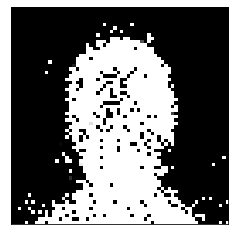

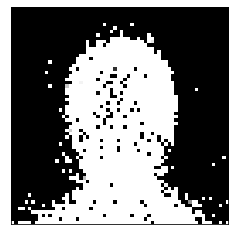

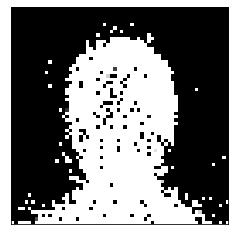

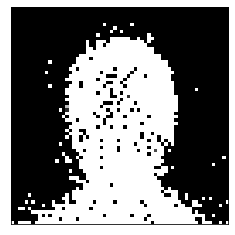

In [20]:
generated_samples = generated_samples.cpu().detach()

for i in range(4):
    fig = plt.figure()
    plt.imshow(generated_samples[i].reshape(image_size, image_size), cmap="gray_r", figure=fig)
    plt.xticks([])
    plt.yticks([])
    fig.savefig(f"{path}/figure_{i}.png")